# Efficiently process dataframes

## Import dependencies

In [1]:
# For basic data manipulation
import pandas as pd

# For wav files processing
import librosa
import wavfile

# For parallelization
from tqdm import tqdm

#### <font color='orange'>Comment 1</font>
- check differences between `import wavfile` and `from scipy.io import wavfile`


## Define auxiliary functions and parameters

In [2]:
# Hyperparameters
class HParams(object):
    """ Hparams was removed from tf 2.0alpha so this is a placeholder
    """

    def __init__(self, **kwargs):
        self.set_defaults()
        self.__dict__.update(kwargs)

    def set_defaults(self):
        self.win_length_ms = 5
        self.hop_length_ms = 1
        self.n_fft = 1024
        self.ref_level_db = 20
        self.min_level_db = -60
        self.preemphasis = 0.97
        self.num_mel_bins = 64
        self.mel_lower_edge_hertz = 200
        self.mel_upper_edge_hertz = 15000
        self.power = 1.5  # for spectral inversion
        self.griffin_lim_iters = 50
        self.butter_lowcut = 500
        self.butter_highcut = 15000
        self.reduce_noise = False
        self.noise_reduce_kwargs = {}
        self.mask_spec = False
        self.mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
        self.nex = -1
        self.n_jobs = -1
        self.verbosity = 1

    def save(self):
        raise NotImplementedError

    def load(self):
        raise NotImplementedError
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=15000,
    butter_lowcut = 500,
    butter_highcut = 15000,
    ref_level_db = 20,
    min_level_db = -30,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
    )

In [3]:
# Functions
def read_wav(wav_loc, method="librosa", **kwargs):
    """ read wav using either librosa or scipy
    """
    if method == "librosa":
        if "sr" not in kwargs.keys():
            kwargs["sr"] = None
        data, rate = librosa.core.load(wav_loc, **kwargs)
    elif method == "scipy":
        rate, data = wavfile.read(wav_loc) # TODO: requires package wavfile, not scipy
    return rate, data

def load_wav(wav_loc, catch_errors=True, method="librosa", **kwargs):
    if catch_errors:
        try:
            rate, data = read_wav(wav_loc, method=method, **kwargs)
            return rate, data
        except Exception as e:
            print(e)
            return None, None
    else:
        rate, data = read_wav(wav_loc, method=method, **kwargs)
        return rate, data
    
def prepare_wav(wav_loc, hparams=None): # TODO: like this, this function is entirely equivalent to `load_wav`
    """ load wav and convert to correct format
    """
    # get rate and date
    rate, data = load_wav(wav_loc)

    return rate, data

## Parse the dataframe

In [4]:
df = pd.read_csv("test_input.csv")
df.head()

,start_time,end_time,participant,utterance,key,language,uid
0,629.96,630.51,A,aha,/german1/5298,german,german-059-255-629960
1,398.87,399.33,A,aha,/german1/5298,german,german-059-151-398870
2,2009.10,2009.50,tx@ADUSBS,aoq,/sambas1/SBS-20111031,sambas,sambas-24-0883-2009100
3,1782.89,1783.40,tx@JEPSBS,aoq,/sambas1/SBS-20111031,sambas,sambas-24-0764-1782890
4,341.41,341.83,B,mhm,/german1/4123,german,german-008-097-341410


## Understand the dataframe

In [5]:
def get_row_times(df, uid):
    return df[df["uid"] == uid].start_time.values

def get_times_loop(df):
    df["times"] = df.apply(lambda row: get_row_times(df, row.uid), axis=1)
    return df

def get_times(df):
    df["times"] = df["start_time"]
    return df

get_row_times(df, 'german-059-255-629960')

array([629.96])

## Define the analysis
The function below defines our analysis. For each row in the dataframe it:
1. Opens the `.wav` file listed in `key`.
2. Extracts the values between `start_time` and `end_time`.
3. Appends it in a new column called "audio".
4. Extracts the audio bit rate.
5. Appends it in a new column called "rate".
6. Returns the enriched data frame.

This is the process we want to optimize.

In [6]:
def get_row_audio(df, wav_loc, hparams):
    """ load audio and grab individual snippets
    TODO: for large sparse WAV files, the audio should be loaded only for the syllable
    """

    # load audio
    rate, data = prepare_wav(wav_loc, hparams)
    data = data.astype('float32')

    # get audio for each word (row) in data frame #TODO: why not stick to the function name, extract only one row, and perform the loop outside?
    df["audio"] = [
        data[int(st * rate) : int(et * rate)]
        for st, et in zip(df.start_time.values, df.end_time.values)
    ]

    df["rate"] = rate

    return df

The wrapper below will be convenient, as most of the information on file location is already contained in `df`.

In [7]:
def get_row_audio_path(df, hparams = hparams, path='audio_files'):
    wav_loc = path + df.key + ".wav" # Build file location from data frame
    return get_row_audio(df, wav_loc, hparams)


#### <font color='orange'>Comment 2</font>
- The rate column is not correct (cf test_output.csv) 
- Row 2 and 16 are missing wav data  

## Optimizations

I propose the following approach.
First of all, define a function that operates on a single row.
This would be at atomic task.
Afterwards, we'll compare different methods to complete the whole task.

In [8]:
def get_row_audio_pablo(row, path='audio_files', hparams=hparams, verbose=False):
    """ load audio and grab individual snippets
    TODO: for large sparse WAV files, the audio should be loaded only for the syllable
    """
    # Build filename 
    wav_loc = path + row["key"] + ".wav"
    
    if verbose:
        print(wav_loc)
    
    # Load audio
    data, rate = librosa.core.load(wav_loc)

    # Renormalize
    data = data.astype('float32')
    
    # get audio for each word (row) in data frame #TODO: why not stick to the function name, extract only one row, and perform the loop outside?
    #audio = [
    #    data[int(st * rate) : int(et * rate)]
    #    for st, et in zip(row.start_time, row.end_time)
    #]

    audio = data
    return audio, rate

get_row_audio_pablo(df.iloc[0, :])


(array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
        -0.00074906, -0.00034924], dtype=float32),
 22050)

In [9]:
N = 2 #len(df) for doing all

### Loop

In [10]:
%%time

rates = []
audios = []
for i in range(N):
    audio, rate = get_row_audio_pablo(df.iloc[i, :], verbose=True)
    rates.append(rate)
    audios.append(audio)

audio_files/german1/5298.wav
audio_files/german1/5298.wav
CPU times: user 1.54 s, sys: 358 ms, total: 1.9 s
Wall time: 1.91 s


### Loop with preallocated memory

In [11]:
%%time

rates = [None]*N
audios = [None]*N
for i in range(N):
    audio, rate = get_row_audio_pablo(df.iloc[i, :], verbose=True)
    rates[i] = rate
    audios[i] = audio

audio_files/german1/5298.wav
audio_files/german1/5298.wav
CPU times: user 1.42 s, sys: 319 ms, total: 1.74 s
Wall time: 1.73 s


### Using `map`

In [12]:

rows = [df.iloc[i] for i in range(N)]
list(map(get_row_audio_pablo, rows))

[(array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
         -0.00074906, -0.00034924], dtype=float32),
  22050),
 (array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
         -0.00074906, -0.00034924], dtype=float32),
  22050)]

## Using dask bags

In [13]:
import dask.bag as db

CPU times: user 27.6 ms, sys: 3.94 ms, total: 31.5 ms
Wall time: 233 ms


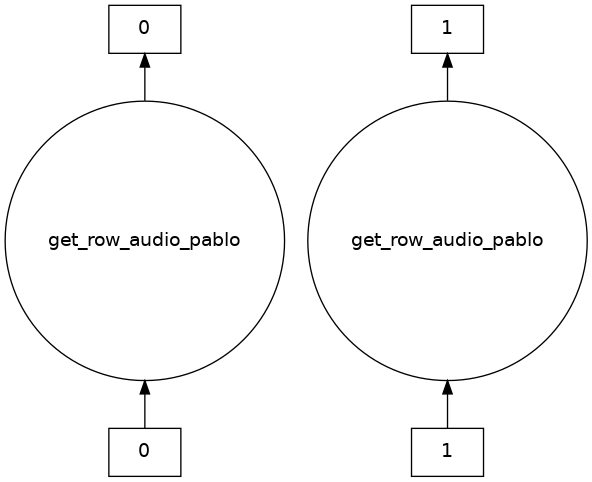

In [14]:
%%time

bag = db.from_sequence(rows) # Declare bag of parallelizable tasks
bag.map(get_row_audio_pablo).visualize() # Visualize the task tree


In [15]:
bag.map(get_row_audio_pablo).compute() # Execute the tasks in parallel

[(array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
         -0.00074906, -0.00034924], dtype=float32),
  22050),
 (array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
         -0.00074906, -0.00034924], dtype=float32),
  22050)]